In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from graphdatascience import GraphDataScience

import warnings

warnings.filterwarnings("ignore")

In [2]:
host = "bolt://localhost:7687"
user = "neo4j"
password = "letmein"

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

2.1.2


In [3]:
schema = gds.run_cypher(
    """
CALL apoc.meta.stats()
YIELD labels, relTypesCount
"""
)

In [4]:
schema["labels"].to_list()

[{'User': 33732, 'Device': 51451, 'IP': 585855, 'Node': 3, 'Card': 118818}]

In [5]:
schema["relTypesCount"].to_list()

[{'HAS_IP': 1488949,
  'REFERRED': 1870,
  'REL': 1,
  'USED': 55026,
  'HAS_CC': 128066,
  'P2P': 102832}]

In [6]:
gds.run_cypher(
    """
MATCH (u:User)
OPTIONAL MATCH (u)-[r:P2P]->(receiver)
WITH u,
     date().year - min(r.transactionDateTime).year AS accountYears,
     count(distinct receiver) AS sentToUsersCount
// store as node property
SET u.accountYears = coalesce(accountYears, 0),
    u.sentToUsersCount = coalesce(sentToUsersCount,0)
"""
)

""


In [7]:
G, res = gds.graph.project(
    "p2p",
    "User",
    "P2P",
    relationshipProperties=["totalAmount"],
    nodeProperties=["avgTransactionAmount", "accountYears"],
)

In [8]:
res

nodeProjection            {'User': {'label': 'User', 'properties': {'avg...
relationshipProjection    {'P2P': {'orientation': 'NATURAL', 'aggregatio...
graphName                                                               p2p
nodeCount                                                             33732
relationshipCount                                                    102832
projectMillis                                                           104
Name: 0, dtype: object

In [9]:
wcc = gds.wcc.mutate(G, mutateProperty="wcc")
wcc.head()

mutateMillis                                                             0
nodePropertiesWritten                                                33732
componentCount                                                        7743
componentDistribution    {'p99': 12, 'min': 1, 'max': 11311, 'mean': 4....
postProcessingMillis                                                     5
Name: 0, dtype: object

In [10]:
wcc["componentDistribution"]

{'p99': 12,
 'min': 1,
 'max': 11311,
 'mean': 4.3564509879891515,
 'p90': 4,
 'p50': 2,
 'p999': 39,
 'p95': 6,
 'p75': 3}

In [11]:
largestComponentId = (
    gds.graph.streamNodeProperty(G, "wcc")
    .groupby("propertyValue")
    .size()
    .to_frame("componentSize")
    .reset_index()
    .sort_values(by="componentSize", ascending=False)["propertyValue"][0]
)

largestComponentGraph, res = gds.beta.graph.project.subgraph(
    "largestComponent", G, f"n.wcc = {largestComponentId}", "*"
)

In [12]:
gds.degree.mutate(
    largestComponentGraph,
    relationshipWeightProperty="totalAmount",
    mutateProperty="weightedOutdegree",
)

gds.degree.mutate(
    largestComponentGraph,
    orientation="REVERSE",
    relationshipWeightProperty="totalAmount",
    mutateProperty="weightedIndegree",
)

nodePropertiesWritten                                                 11311
centralityDistribution    {'p99': 28470.124969482422, 'min': 0.0, 'max':...
mutateMillis                                                              0
postProcessingMillis                                                    210
preProcessingMillis                                                       0
computeMillis                                                             1
configuration             {'jobId': 'b73472ba-9168-4178-a32c-c1bcd6fe3eb...
Name: 0, dtype: object

In [13]:
gds.betweenness.mutate(largestComponentGraph, mutateProperty="betweenness")
gds.beta.closeness.mutate(largestComponentGraph, mutateProperty="closeness")

BetweennessCentrality:   0%|          | 0/100 [00:00<?, ?%/s]

nodePropertiesWritten                                                 11311
mutateProperty                                                    closeness
centralityDistribution    {'p99': 1.0000073909759521, 'min': 0.0, 'max':...
mutateMillis                                                              0
postProcessingMillis                                                     30
preProcessingMillis                                                       1
computeMillis                                                          2059
configuration             {'jobId': '5c4e9a27-4e08-43da-91ae-a3b1a37ec20...
Name: 0, dtype: object

In [14]:
features_df = gds.graph.streamNodeProperties(
    largestComponentGraph,
    [
        "weightedOutdegree",
        "weightedIndegree",
        "avgTransactionAmount",
        "accountYears",
        "betweenness",
        "closeness",
    ],
)
features_df.head()

,nodeId,nodeProperty,propertyValue
0,20000,weightedOutdegree,0.0
1,20000,weightedIndegree,200.0
2,20000,avgTransactionAmount,0.0
3,20000,accountYears,0.0
4,20000,betweenness,0.0


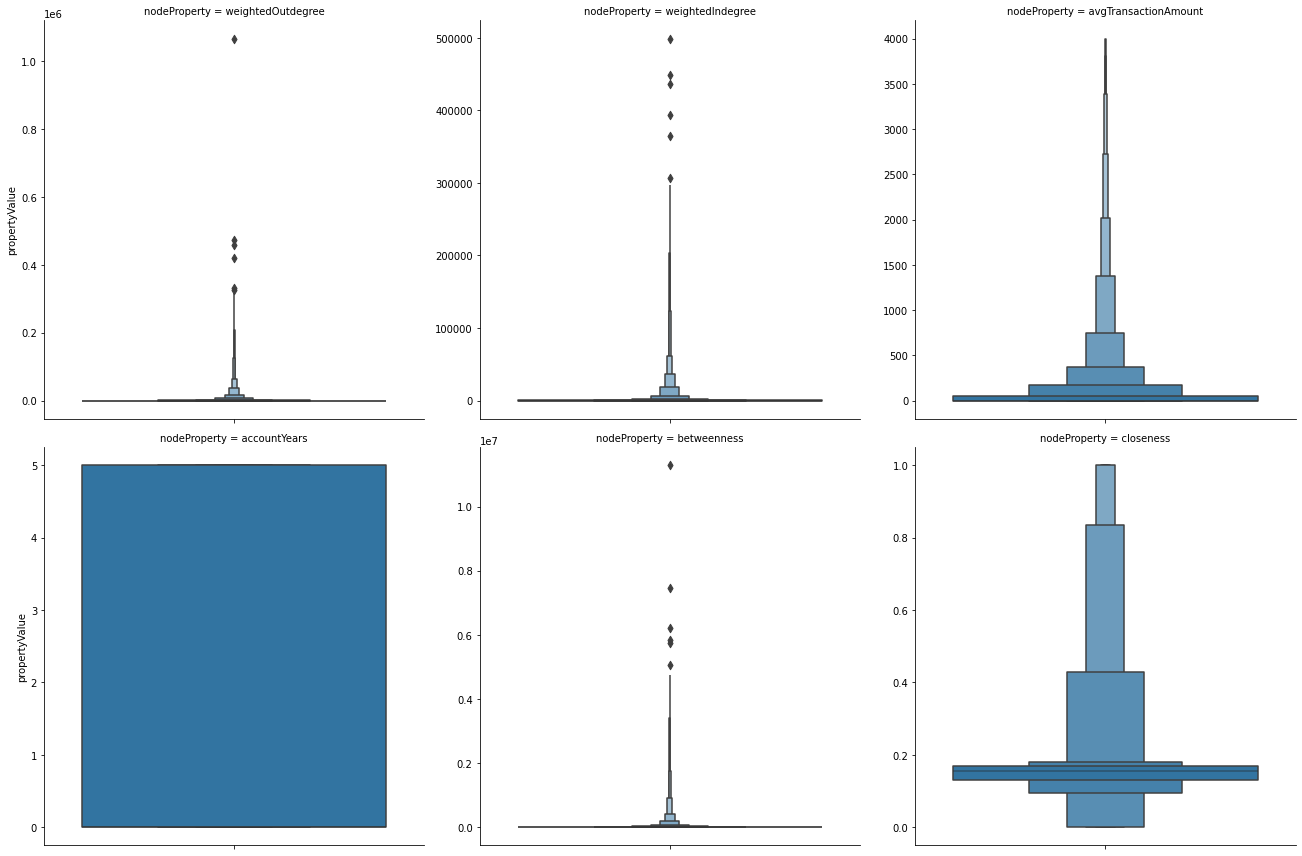

In [15]:
sns.catplot(
    col="nodeProperty",
    y="propertyValue",
    height=6,
    data=features_df,
    kind="boxen",
    sharey=False,
    col_wrap=3,
)

In [16]:
data = gds.graph.streamNodeProperties(
    largestComponentGraph,
    [
        "weightedOutdegree",
        "weightedIndegree",
        "avgTransactionAmount",
        "accountYears",
        "betweenness",
        "closeness",
    ],
    separate_property_columns=True,
)
data.head()

nodeProperty,nodeId,accountYears,avgTransactionAmount,betweenness,closeness,weightedIndegree,weightedOutdegree
0,0,4.0,98.782609,24985.335938,0.163444,1000.00,2272.0
1,1,4.0,100.000000,0.000000,0.075315,100.00,100.0
2,3,4.0,122.000000,0.000000,0.137684,167.22,122.0
3,4,0.0,0.000000,0.000000,0.171180,210.00,0.0
4,14,4.0,368.000000,0.000000,0.172998,500.00,2576.0


In [17]:
data.describe()

nodeProperty,nodeId,accountYears,avgTransactionAmount,betweenness,closeness,weightedIndegree,weightedOutdegree
count,11311.000000,11311.000000,11311.000000,1.131100e+04,11311.000000,11311.000000,1.131100e+04
mean,16789.334542,2.216426,99.198514,1.967391e+04,0.180162,1527.190995,1.527191e+03
std,9749.632411,2.349186,331.473144,2.176740e+05,0.175071,13206.700185,1.637541e+04
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,8308.000000,0.000000,0.000000,0.000000e+00,0.129951,5.000000,0.000000e+00
50%,16756.000000,0.000000,0.000000,0.000000e+00,0.155281,30.000000,0.000000e+00
75%,25289.000000,5.000000,54.687500,0.000000e+00,0.170334,300.000000,1.390000e+02
max,33724.000000,5.000000,4000.000000,1.129122e+07,1.000000,498911.090000,1.065990e+06


<AxesSubplot:xlabel='nodeProperty', ylabel='nodeProperty'>

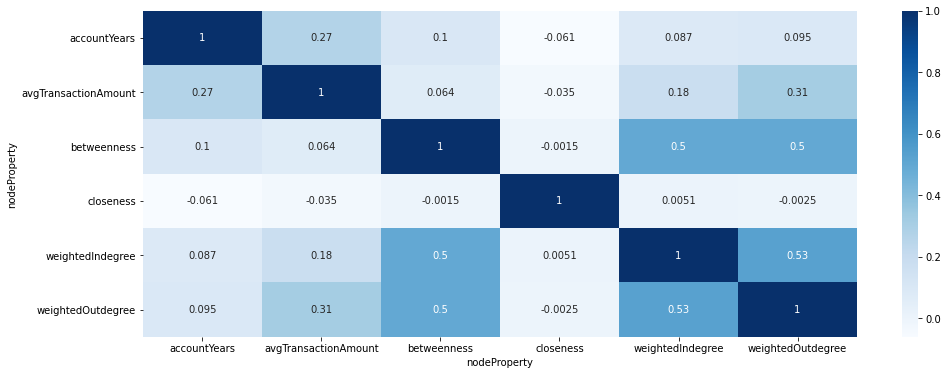

In [18]:
plt.figure(figsize=(16, 6))

corr = data.drop("nodeId", axis=1).corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    cmap="Blues",
    annot=True,
)

In [19]:
gds.alpha.scaleProperties.mutate(
    largestComponentGraph,
    mutateProperty="features",
    nodeProperties=[
        "weightedOutdegree",
        "weightedIndegree",
        "avgTransactionAmount",
        "accountYears",
        "betweenness",
        "closeness",
    ],
    scaler="StdScore",
)

nodePropertiesWritten                                                11311
mutateMillis                                                             0
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                            2
configuration            {'jobId': '388ba276-10cb-4773-9e9c-b7e2a099532...
Name: 0, dtype: object

In [20]:
kmeans_df = gds.alpha.kmeans.stream(
    largestComponentGraph, nodeProperty="features", k=6, randomSeed=42
)
kmeans_df.head()

,nodeId,communityId
0,20000,0
1,20011,2
2,20014,0
3,20017,3
4,20026,1


In [21]:
merged_df = data.merge(kmeans_df, on="nodeId")

In [22]:
merged_df.drop("nodeId", axis=1).groupby("communityId").size().to_frame(
    "communitySize"
).reset_index()

,communityId,communitySize
0,0,3225
1,1,4870
2,2,570
3,3,1961
4,4,217
5,5,468


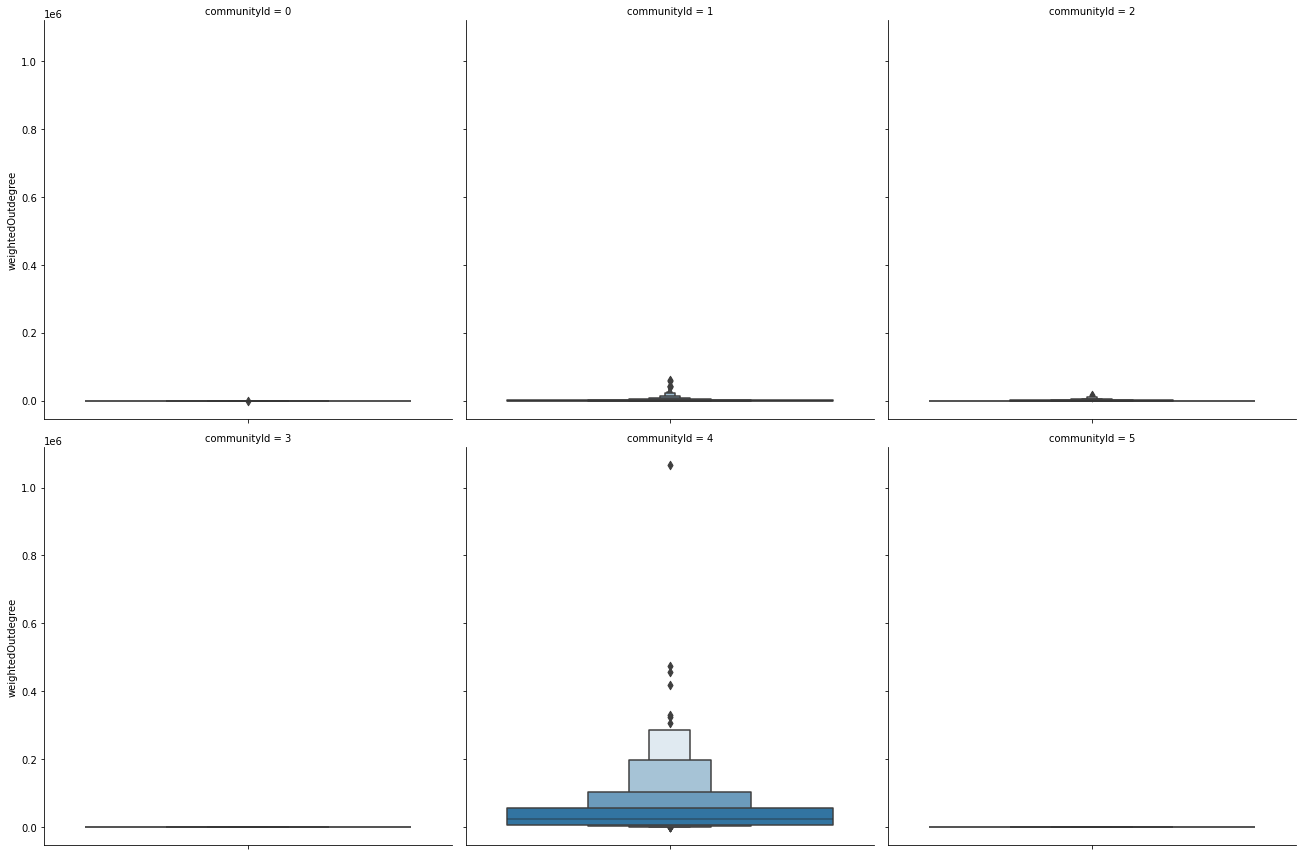

In [23]:
sns.catplot(
    col="communityId",
    y="weightedOutdegree",
    height=6,
    data=merged_df,
    kind="boxen",
    col_wrap=3,
)

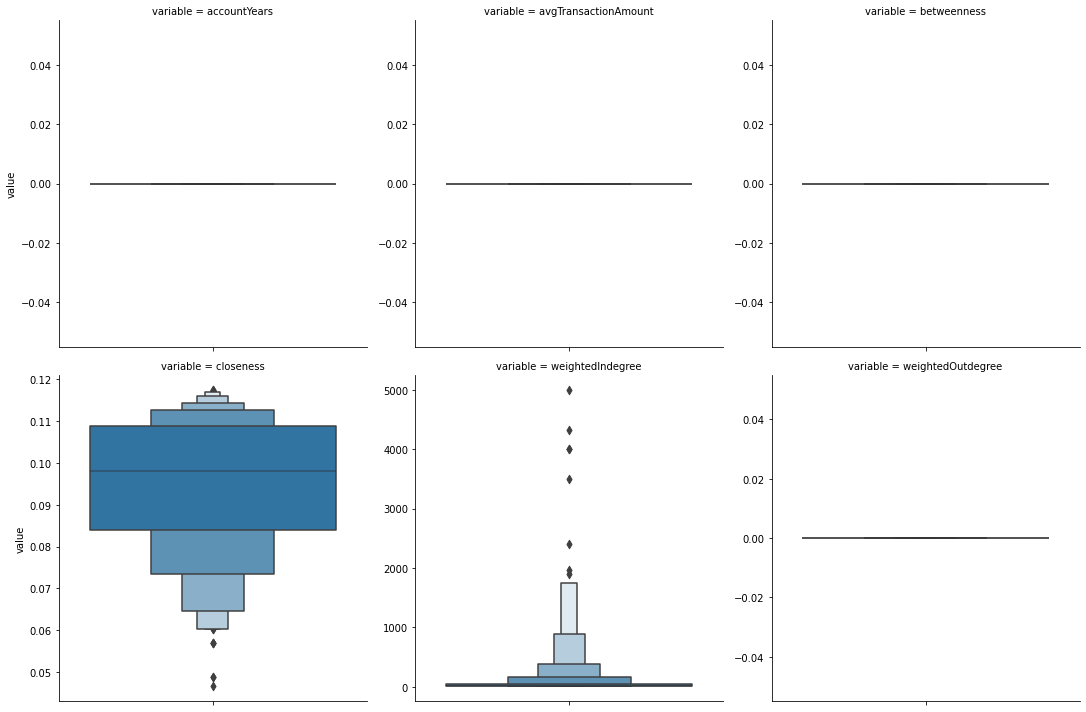

In [24]:
community_5 = (
    merged_df[merged_df["communityId"] == 5]
    .drop("communityId", axis=1)
    .melt(id_vars="nodeId")
)
sns.catplot(
    data=community_5, y="value", col="variable", col_wrap=3, kind="boxen", sharey=False
)

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

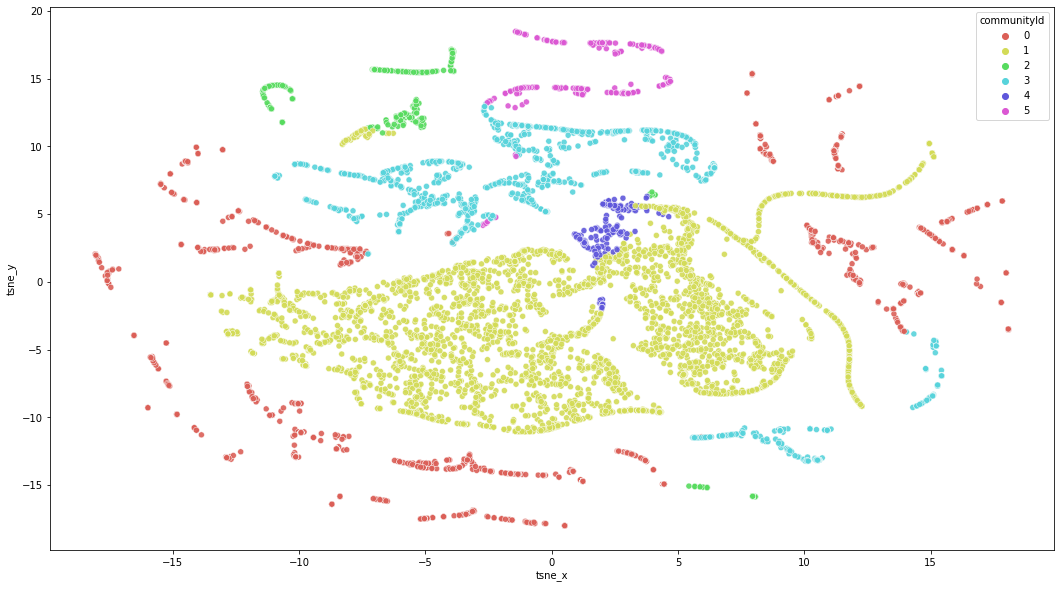

In [25]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne_data = merged_df.drop(["nodeId", "communityId"], axis=1).values.tolist()

scaler = StandardScaler()
scaler.fit(tsne_data)

tsne = TSNE(
    n_components=2, n_iter=500, random_state=42, perplexity=50, learning_rate=20
)
tsne_results = tsne.fit_transform(scaler.transform(tsne_data))

merged_df["tsne_x"] = [x[0] for x in list(tsne_results)]
merged_df["tsne_y"] = [x[1] for x in list(tsne_results)]

plt.figure(figsize=(18, 10))
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    hue="communityId",
    palette=sns.color_palette("hls", 6),
    data=merged_df,
    legend="full",
    alpha=0.9,
)

In [26]:
G.drop()
largestComponentGraph.drop()

graphName                                             largestComponent
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                        11311
relationshipCount                                                52272
configuration        {'jobId': '6965913e-afcd-4c6a-8647-f47beb0935d...
density                                                       0.000409
creationTime                       2022-06-27T16:21:11.258621000+02:00
modificationTime                   2022-06-27T16:21:28.076215000+02:00
schema               {'graphProperties': {}, 'relationships': {'P2P...
Name: 0, dtype: object